## Visualize trained models

This notebook helps visualize the training progress as well as the resulting model

#### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import IPython
from IPython.display import display, HTML

from State_Generator import Generator
from Model import Complex_CA

#### Load model and data

In [2]:
batch_size = 8
device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
model = Complex_CA(device, 8)
#model.load_state_dict(torch.load('models/complex_ca_stationary.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_best1.pth'))
model.load_state_dict(torch.load('models/complex_ca_moving_temp1.pth'))

#model.load_state_dict(torch.load('models/complex_ca_moving_temp49.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_temp8.pth'))
#model.load_state_dict(torch.load('models/complex_ca5.pth'))

model = model.to(device)
losses = np.load('losses.npy')
#device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
generator = Generator(device, False)

#### Visualize loss during training

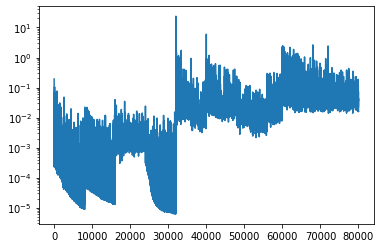

In [3]:
#fig, axes = plt.subplots()
plt.plot(losses)
plt.yscale('log')
plt.show()


#### Visualize CA - Animate

In [4]:
#state = generator.generate_stationary_state()
state = generator.generate_moving_state(1)

def extract_data(state):
    return state.x.detach().cpu().numpy()[0]

@torch.no_grad()
def animate(i):
    global state
    x, food, live_count = model(state.x, state.food, 1)
    state.x = x
    state.food = food
    mat.set_data(extract_data(state)) 

fig, ax = plt.subplots()
mat = ax.matshow(extract_data(state), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

TypeError: Generator.generate_moving_state() missing 1 required positional argument: 'batch_size'

#### Visualize Target data:

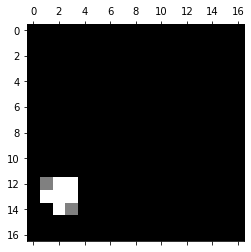

In [ ]:
#use generator to test generate_moving_state
generator = Generator(device, False)
state = generator.get_centered_CA()
food = generator.random_food_noncentered()

@torch.no_grad()
def animate(i):
    global state
    #generator.generate_moving_state(100)
    state = generator.move_towards_food(state, food)
    mat.set_data(state)

fig, ax = plt.subplots()
mat = ax.matshow(state, cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=80, interval=100).to_jshtml())

#### Combined simulation and CA movement

tensor(0., device='mps:0')
live_count:  12.968696594238281
tensor(0., device='mps:0')
live_count:  13.005285263061523
tensor(0., device='mps:0')
live_count:  13.102106094360352
tensor(0., device='mps:0')
live_count:  13.252553939819336
tensor(2., device='mps:0')
live_count:  13.456680297851562
tensor(8., device='mps:0')
live_count:  13.709479331970215
tensor(27., device='mps:0')
live_count:  14.007730484008789
tensor(52., device='mps:0')
live_count:  14.349050521850586
tensor(66., device='mps:0')
live_count:  14.73164176940918
tensor(78., device='mps:0')
live_count:  15.149916648864746
tensor(85., device='mps:0')
live_count:  15.605815887451172
tensor(87., device='mps:0')
live_count:  16.098190307617188
tensor(89., device='mps:0')
live_count:  16.623043060302734
tensor(91., device='mps:0')
live_count:  17.176034927368164
tensor(100., device='mps:0')
live_count:  17.75182342529297
tensor(103., device='mps:0')
live_count:  18.34368133544922
tensor(109., device='mps:0')
live_count:  18.95

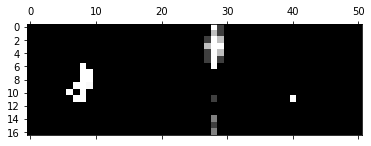

In [5]:
#state = generator.generate_stationary_state()
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    return np.hstack((cell.detach().cpu().numpy()[0, 0], target.detach().cpu().numpy()[0], state.food.detach().cpu().numpy()[0]))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global state
    global food_coord
    cell, food, live_count = model(cell, state.food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
    mat.set_data(extract_data(cell, target)) 

cell = state.x
target = state.x[:, 0]
food_coord = (state.food==torch.max(state.food)).nonzero()
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())